# Actual Prediction

In [1]:
#Declare Variables
import numpy as np
import csv,sklearn
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numpy import std
from numpy import mean
from pandas import read_csv
from sklearn import metrics
from matplotlib import pyplot
from collections import Counter
import matplotlib.pyplot as plt #for visualization and plot
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold

In [2]:
#glucose and output data
data = pd.read_csv('diabetesmerge.csv')

In [3]:
data.head()

,Glucose,BloodPressure,Insulin,Age,Output
0,89,66,94,21,0
1,137,40,168,33,2
2,78,50,88,26,0
3,197,70,543,53,2
4,189,60,846,59,2


In [4]:
# Split data into train and test set
splitRatio = 0.2

train , test = train_test_split(data,test_size = splitRatio,random_state = 123)

X_train = train[[x for x in train.columns if x not in ["Output"]]]
y_train = train[["Output"]]

X_test  = test[[x for x in test.columns if x not in ["Output"]]]
y_test  = test[["Output"]]

Class=2, n=70 (47.945%)
Class=0, n=36 (24.658%)
Class=1, n=40 (27.397%)


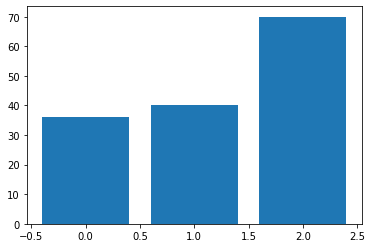

In [5]:
#Visualizing Class Distribution
# summarize 
out = y_test['Output']
counter = Counter(out)
for k,v in counter.items():
	per = v / len(out) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [6]:
# evaluate the Random forest model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define the model
modelRF = RandomForestClassifier(max_depth= 3, max_features=2, n_estimators=50)
#modelRF = RandomForestClassifier(max_depth= 3, max_features=2, n_estimators=50,min_samples_split=3, min_samples_leaf=4)

# evaluate the model
scores = evaluate_model(X_train, y_train, modelRF)
modelRF.fit(X_train, y_train)
# summarize performance
print('Mean Accuracy: %.8f (%.8f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.98795068 (0.00611987)


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [13]:
# Grid Search for optimizing random forest parameters

param_grid = [
    {'max_depth': [2, 3, 5,6,7,8,9,10], 'n_estimators': [10, 50, 100],'max_features': [2, 3, 4]}]

modelRF_grid = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(modelRF_grid, param_grid,
                           scoring='accuracy',
                           return_train_score=True,
                           cv=cv,
                          )
grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [2, 3, 5, 6, 7, 8, 9, 10],
                          'max_features': [2, 3, 4],
                          'n_estimators': [10, 50, 100]}],
             return_train_score=True, scoring='accuracy')

In [8]:
grid_search.best_params_

{'max_depth': 3, 'max_features': 4, 'n_estimators': 100}

In [9]:
cv_scores = grid_search.cv_results_

In [10]:
##printing all the parameters along with their scores
for mean_score, params in zip(cv_scores['mean_test_score'], cv_scores["params"]):
    print(mean_score, params)

0.9564838990426457 {'max_depth': 2, 'max_features': 2, 'n_estimators': 10}
0.9686684073107049 {'max_depth': 2, 'max_features': 2, 'n_estimators': 50}
0.9625761531766753 {'max_depth': 2, 'max_features': 2, 'n_estimators': 100}
0.9808529155787642 {'max_depth': 2, 'max_features': 3, 'n_estimators': 10}
0.9869451697127938 {'max_depth': 2, 'max_features': 3, 'n_estimators': 50}
0.9869451697127938 {'max_depth': 2, 'max_features': 3, 'n_estimators': 100}
0.9869451697127938 {'max_depth': 2, 'max_features': 4, 'n_estimators': 10}
0.9869451697127938 {'max_depth': 2, 'max_features': 4, 'n_estimators': 50}
0.9869451697127938 {'max_depth': 2, 'max_features': 4, 'n_estimators': 100}
0.9825935596170583 {'max_depth': 3, 'max_features': 2, 'n_estimators': 10}
0.9852045256744996 {'max_depth': 3, 'max_features': 2, 'n_estimators': 50}
0.9869451697127938 {'max_depth': 3, 'max_features': 2, 'n_estimators': 100}
0.9947780678851175 {'max_depth': 3, 'max_features': 3, 'n_estimators': 10}
0.9947780678851175 {'

In [15]:
#y_pred_class = grid_search.predict(X_test)
y_pred_class = modelRF.predict(X_test)

In [16]:
# calculate accuracy
print(metrics.accuracy_score(y_test, y_pred_class, normalize=True))

0.9726027397260274


In [17]:
# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion)

[[36  0  0]
 [ 0 40  0]
 [ 4  0 66]]


In [7]:
# Compare Prediction 
print("Train acc: " , modelRF.score(X_train, y_train))
print("Test acc: ", modelRF.score(X_test, y_test))

Train acc:  0.9879518072289156
Test acc:  0.9726027397260274


In [23]:
# Compare Prediction 
print("Train acc: " , grid_search.score(X_train, y_train))
print("Test acc: ", grid_search.score(X_test, y_test))

Train acc:  1.0
Test acc:  1.0


In [19]:
new_df = pd.DataFrame([[100,300,75,64]])
# We predict insulin
prediction = grid_search.predict(new_df)


In [20]:
print(prediction)

[1]


In [21]:
# Prediction
prediction = np.around(modelRF.predict(X_test))
print(metrics.classification_report(y_test,prediction, digits=8))

              precision    recall  f1-score   support

           0  0.90000000 1.00000000 0.94736842        36
           1  1.00000000 1.00000000 1.00000000        40
           2  1.00000000 0.94285714 0.97058824        70

    accuracy                      0.97260274       146
   macro avg  0.96666667 0.98095238 0.97265222       146
weighted avg  0.97534247 0.97260274 0.97292082       146



In [22]:
# Plot ROC Curve

n_classes = 3
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_class[:, i]) #needs label binarizer to work
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.8f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

TypeError: '(slice(None, None, None), 0)' is an invalid key